In [1]:
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

# from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.case_db import *
from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = {
    "nofimp" : "spr45_nofimp",
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(db.casepaths[toload[name]], guard_replace = False)


Loading spr45_nofimp


c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In
-----
Ion source                 3150.349
Electron source            3150.349
Recycled neutrals          200.795

Out
-----
Excitation radiation      -1038.635
Recombination radiation   -0.172
Ion sheath loss           -1516.987
Electron sheath loss      -3368.204
Neutral reflection        0.000

Total heat balance
-----
Total in:                  6501.493 [MW]
Total out                 -5923.998 [MW]
Imbalance:                 577.495 [MW]  /  8.88%

Particle balance
-----
Ion particle loss          4.178e+26
Recycled neutral source    4.178e+26


Text(0.5, 0, 'Time [s]')

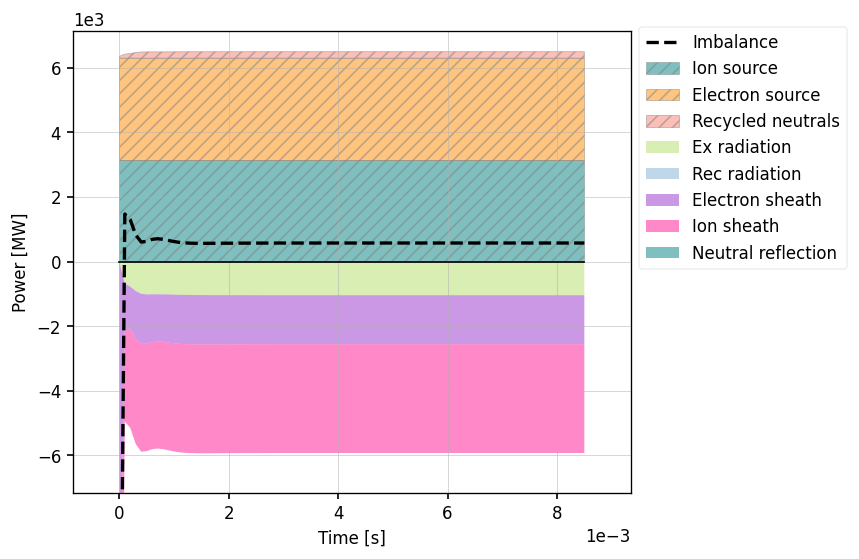

In [37]:
# ds = cases["frecoff"]
ds = cs["nofimp"].ds


"""
Calculates heat balance for 1D case
You MUST provide a dataset without guard replacement
"""

domain = ds.isel(pos = slice(2,-2))
radex = (domain["Rd+_ex"] * domain["dv"]).sum("pos").values*1e-6 if "Rd+_ex" in ds.data_vars else np.zeros_like(ds["t"])
radrec = (domain["Rd+_rec"] * domain["dv"]).sum("pos").values*1e-6 if "Rd+_rec" in ds.data_vars else np.zeros_like(ds["t"])
isrc = (domain["Pd+_src"] * domain["dv"] * 3/2).sum("pos").values*1e-6
esrc = (domain["Pe_src"] * domain["dv"] * 3/2).sum("pos").values*1e-6
nrefl = (domain["Ed_target_refl"] * domain["dv"]).sum("pos").values*1e-6 if "Ed_target_refl" in ds.data_vars else np.zeros_like(ds["t"])
nrec = (domain["Ed_target_recycle"] * domain["dv"]).sum("pos").values*1e-6 if "Ed_target_recycle" in ds.data_vars else np.zeros_like(ds["t"])

def wall(param):
    return (ds[param].isel(pos = -2) + ds[param].isel(pos = -3)) * 0.5

q_e = constants("q_e")
Mi = constants("mass_p")*2

da =  (wall("J") / np.sqrt(wall("g_22"))) * (wall("dx") * wall("dz"))
pflux = wall("Ne") * wall("Vd+") * float(da)
isheath = -(2.5 * wall("Td+")*q_e) * pflux * 1e-6
esheath = -(4.5 * wall("Te")*q_e) * pflux * 1e-6

total_in = isrc+esrc+nrec
total_out = radex+radrec+isheath+esheath+nrefl
imbalance = total_in + total_out
imbalance_ratio = imbalance/total_in

recycled_flow = (domain["Sd_target_recycle"] * domain["dv"]).sum("pos").values if "Sd_target_recycle" in ds.data_vars else np.zeros_like(ds["t"])

print("In")
print("-----")

print(f"Ion source                 {isrc[-1]:.3f}")
print(f"Electron source            {esrc[-1]:.3f}")
print(f"Recycled neutrals          {nrec[-1]:.3f}")

print("\nOut")
print("-----")

print(f"Excitation radiation      {radex[-1]:.3f}")
print(f"Recombination radiation   {radrec[-1]:.3f}")
print(f"Ion sheath loss           {isheath[-1]:.3f}")
print(f"Electron sheath loss      {esheath[-1]:.3f}")
print(f"Neutral reflection        {nrefl[-1]:.3f}")

print("\nTotal heat balance")
print("-----")

print(f"Total in:                  {total_in[-1]:.3f} [MW]")
print(f"Total out                 {total_out[-1]:.3f} [MW]")
print(f"Imbalance:                 {imbalance[-1]:.3f} [MW]  /  {imbalance_ratio[-1]:.2%}")


print("\nParticle balance")
print("-----")
print(f"Ion sheath loss            {pflux[-1]:.3e}")
print(f"Recycled neutral source    {recycled_flow[-1]:.3e}")

fig, ax = plt.subplots()

ax.plot(ds["t"], total_in+total_out, label = "Imbalance", lw = 2, ls = "--", c = "k")
# ax.plot(ds["t"], total_in, label = "Total sources", lw = 2, ls = ":", c = "k")
ax.plot(ds["t"], np.zeros_like(ds["t"]), lw=1, c="k")

ax.stackplot(ds["t"], [isrc, esrc, nrec], 
             labels = ["Ion source", "Electron source", "Recycled neutrals"], 
             antialiaseds = True, alpha = 0.5, hatch = "///", edgecolor = "grey", linewidth = 0.5)

ax.stackplot(ds["t"], [radex, radrec, isheath, esheath, nrefl], 
             labels = ["Ex radiation", "Rec radiation", "Electron sheath", "Ion sheath", "Neutral reflection", "Recycled neutrals"], 
             antialiaseds = True, alpha = 0.5)



lim = np.max([np.abs(total_in[-1]), np.abs(total_out[-1])]) * 1.1
ax.set_ylim(-lim,lim)

fig.legend(loc="upper left", bbox_to_anchor=(0.9,0.9))
ax.grid(alpha = 1)
ax.set_ylabel("Power [MW]")
ax.set_xlabel("Time [s]")

In [6]:
plt.close("all")
%matplotlib inline

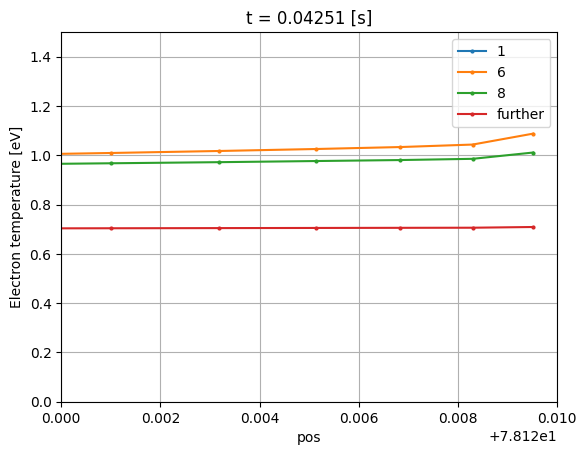

In [28]:
fig, ax = plt.subplots()
for case in toload:

    ds = cs[case].ds.isel(t=-1, pos = slice(2,-2))
    ds["Te"].plot(ax = ax, marker = "o", ms = 2, label = case)
    
ax.set_xlim(78.12,78.130)
ax.set_ylim(0,1.5)
ax.grid()
ax.legend()
# ax.set_yscale("log")